# Predicting the Football EURO 2020
For every major football tournament, there is a little private prediction game at work where there are a few prizes to be won. After finishing in the upper middle of the field at the 2018 World Cup, this year I was ambitious and wanted to build a model that would finish at the top. There was not much time for model development, as I had made the decision only a few days before the opening game. My approach is based on the concept of Elo ratings combined with a Poisson model and an optimisation of results based on the allocation of points in the prediction game. The model derivation will be described in this notebook.

In [1]:
from datetime import date, datetime
# import itertools
from itertools import permutations, product
from matplotlib import pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import seaborn as sns

# Use the fivethirtyeight style for plots
plt.style.use("fivethirtyeight")

## Data Import
Let's start by importing some data with historical results of football national teams from kaggle. [This](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017) dataset covers over 40,000 international football results and gets updated every now and then. So let's import the data and get some initial understanding of the content.

In [34]:
results = pd.read_csv("files/results.csv", parse_dates=["date"])
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42650 entries, 0 to 42649
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        42650 non-null  datetime64[ns]
 1   home_team   42650 non-null  object        
 2   away_team   42650 non-null  object        
 3   home_score  42650 non-null  int64         
 4   away_score  42650 non-null  int64         
 5   tournament  42650 non-null  object        
 6   city        42650 non-null  object        
 7   country     42650 non-null  object        
 8   neutral     42650 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 2.6+ MB


In [3]:
results

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
42645,2021-09-09,Colombia,Chile,3,1,FIFA World Cup qualification,Barranquilla,Colombia,False
42646,2021-09-09,Paraguay,Venezuela,2,1,FIFA World Cup qualification,Asunción,Paraguay,False
42647,2021-09-09,Uruguay,Ecuador,1,0,FIFA World Cup qualification,Montevideo,Uruguay,False
42648,2021-09-09,Argentina,Bolivia,3,0,FIFA World Cup qualification,Buenos Aires,Argentina,False


The data contains results from 42,650 matches (as of October 17, 2021) and ranges from the first official international football match between Scotland and England in 1872 to recent matches in 2021, even if the last update was already a couple of weeks ago. Looking at the columns of the dataset, we observe a boolean column `neutral` which takes the value `True` if the match was played at a neutral location. This information might proof helpful for modeling the home advantage. Furthermore we find a column `tournament` containing an indication about the respective tournament the game was part of. Assuming that friendly matches are less meaningful than the FIFA World Cup finals, this might also be a valuable piece of information.

The data dictionary on the kaggle website states that columns `home_score` and `away_score` contain the final result including extra time, but excluding penalty-shootouts. So let's confirm this by extracting some famous matches that were decided in penalty-shootouts:

In [4]:
match1 = (
    (results["home_team"] == "Italy")
    & (results["away_team"] == "France")
    & (results["date"].dt.year == 2006)
)
match2 = (
    (results["home_team"] == "England")
    & (results["away_team"] == "Germany")
    & (results["date"].dt.year == 1996)
)
results[match1 | match2]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
19740,1996-06-26,England,Germany,1,1,UEFA Euro,London,England,False
28468,2006-07-09,Italy,France,1,1,FIFA World Cup,Berlin,Germany,True


As expected, the penalty-shootouts were not considered in the score. Given that our prediction game evaluates the score after 120 minutes, that is exactly what we want. 

In the next step, we remove matches after 10 June 2021 to reflect the situation at the beginning of the EURO 2020. 

In [5]:
results_before_euro = results[results["date"] < "2021-06-11"].copy()

## Exploratory Data Analysis
Before we start thinking about a suitable prediction model, let's get an overview of the data. First, let's see how the number of international matches is distributed over time. Does the dataset look complete or are we missing any matches? 

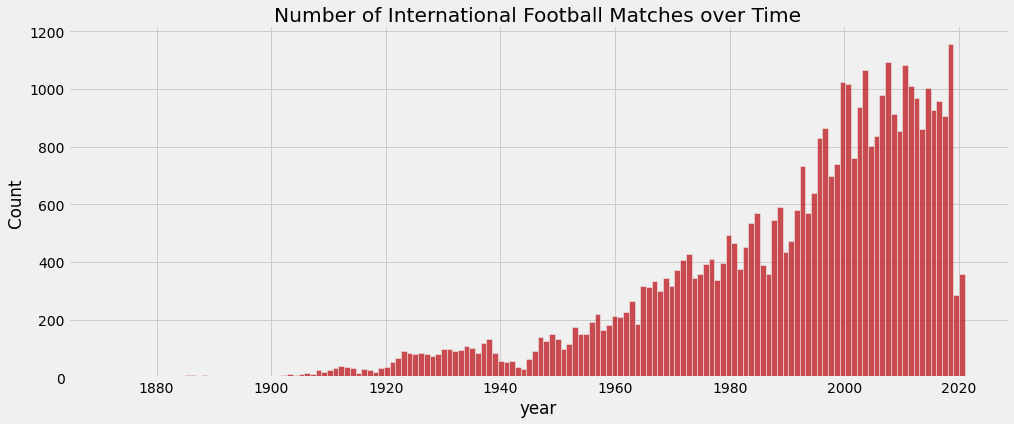

In [6]:
# Set up new column 'year' in the DataFrame
results_before_euro["year"] = results_before_euro["date"].dt.year

# Plot the histogram
fig, ax = plt.subplots(figsize=(15, 6))
n_years = len(results_before_euro["year"].unique())
sns.histplot(
    x="year",
    data=results_before_euro,
    ax=ax,
    bins=n_years,
    color=[0.736, 0.08, 0.101],
)

plt.title("Number of International Football Matches over Time")

# Decluttering
for direction in ["right", "top"]:
    ax.spines[direction].set_visible(False)

plt.show()

Not surprisingly, the number of international matches has increased rather steadily since the beginning of the 20th century with a few major drops during WW I (1914-1918), WW II (1939-1945) and the COVID-19 crisis (2020). Note that the low value for 2021 is not due to COVID-19, but because we removed all matches after 10 June 2021.

With our goal being the prediction of the final results, we are curious to know what the most frequent match result has been and if it has changed over time. Since a large number of matches - especially in final tournaments - were played on neutral ground, it does not make sense to distinguish between home and away teams. A 2-1 victory is thus treated the same as a 1-2 defeat for this analysis.

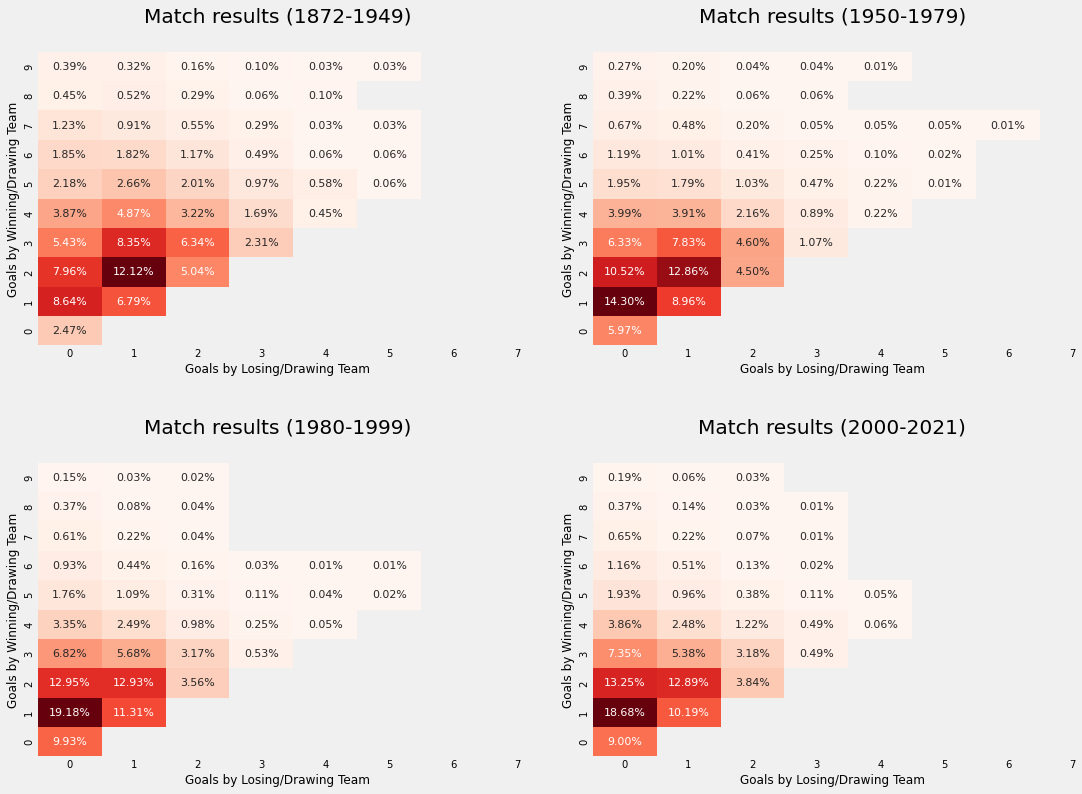

In [7]:
# Create a copy to prevent the original data from being overwritten in the following steps
results_count = results_before_euro[["year", "home_score", "away_score"]].copy()

# Flip the result if away team won (as we make no distinction between 2-1 and 1-2, i.e. we do not care about the winner)
away_wins = (results_count["away_score"] > results_count["home_score"])
results_count.loc[away_wins, "away_score"] = results_before_euro.loc[away_wins, "home_score"]
results_count.loc[away_wins, "home_score"] = results_before_euro.loc[away_wins, "away_score"]

# Create some relevant epochs to demonstrate the evolution of results over time
bins = [0, 1949, 1979, 1999, 2021]
labels = ["1872-1949", "1950-1979", "1980-1999", "2000-2021"]
results_count["epoch"] = pd.cut(results_count["year"], bins=bins, labels=labels)

# Create a heatmap for each epoch
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for label, ax in zip(labels, axes.reshape(-1)):
    # Select matches from the relevant epoch
    filter_epoch = (results_count["epoch"] == label)
    counts = (
        results_count[filter_epoch]
        .value_counts(subset=["home_score", "away_score"], normalize=True)
        .reset_index()
    )

    # Drop results with more than 10 goals scored by the winning team (simplification)
    counts = counts[counts["home_score"] < 10]

    counts = counts.pivot("home_score", "away_score", 0)
    sns.heatmap(
        counts,
        cbar=False,
        annot=True,
        annot_kws={"fontsize": 11},
        fmt=".2%",
        ax=ax,
        cmap=sns.color_palette("Reds", as_cmap=True),
        xticklabels=range(0, 8),
        yticklabels=range(0, 10),
    )

    # Plot formatting
    ax.set_title("Match results (" + label + ")", pad=30)
    ax.set_xlabel("Goals by Losing/Drawing Team", fontsize=12)
    ax.set_ylabel("Goals by Winning/Drawing Team", fontsize=12)
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.set_ylim(0, 10)

plt.tight_layout(pad=3)
plt.show()

It is clearly to see that the most frequent result is a 1-0 win, occuring in roughly 19% of all international football matches in the past 40 years. However, looking at the upperleft subplot, that has not always been the case. In the early days of the game (1872-1949), the most frequent result was a 2-1 win. The figure above also underlines that the number of goals per match has decreased a lot since the beginning of the game and we can confirm this by explicitly calculating the mean number of goals per match for each decade.

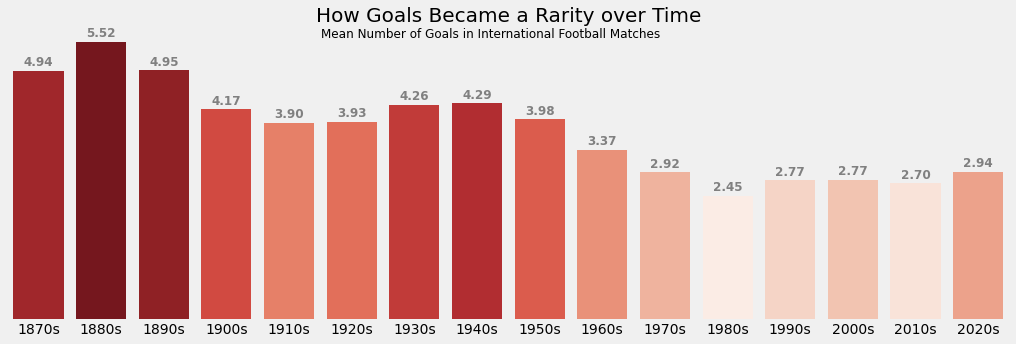

In [8]:
from prediction_game_functions import annotate_plot, declutter_plot

# Split the matches into decades
bins = range(1870, 2031, 10)
labels = [str(bin) + "s" for bin in bins[:-1]]
results_count["decade"] = pd.cut(
    results_count["year"], bins=bins, labels=labels, right=True
)

# Calculate the mean number of goals in each decade and save it as variable `ys`
results_count["goals"] = results_count[["home_score", "away_score"]].sum(axis=1)
ys = results_count.groupby(["decade"]).mean()["goals"].values.reshape(-1)

# Create bar plot with epoch on the x-axis and the mean number of goals as variable y
fig, ax = plt.subplots(figsize=(16, 5))
palette = sns.color_palette("Reds", len(labels))
rank = results_count.groupby("decade").mean()["goals"].argsort().argsort() # Used for colouring the bars
sns.barplot(
    x="decade",
    y="goals",
    data=results_count,
    ax=ax,
    ci=False,
    palette=np.array(palette[::1])[rank],
)
plt.title("How Goals Became a Rarity over Time", fontsize=20)
plt.suptitle("Mean Number of Goals in International Football Matches", fontsize=12, y=0.88)

# Annotate the mean number of goals on top of each bar
annotate_plot(ax, ys)

# Declutter the plot
declutter_plot(ax)

plt.show()

As can be seen from the figure above, the mean number of goals in international matches has almost halved compared to the late 19th century. This decline occurred mainly between the 1950s and 1980s. Since the 1990s, the mean has settled at a constant level between 2.7 and 2.8 goals per match.

With the number of goals scored falling sharply over time, it can be assumed that the proportion of draws has risen. Let's see if this assumption is adequate.

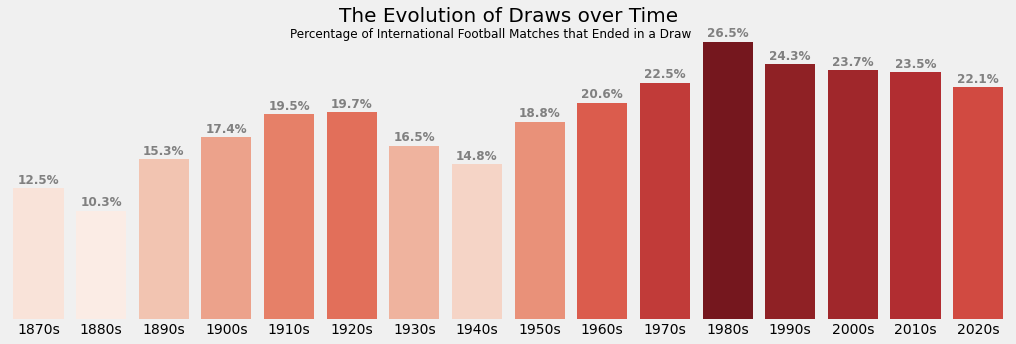

In [9]:
# Create a dummy variable `draw` (1 if score is drawn, 0 otherwise)
results_count["draw"] = (results_count["home_score"] == results_count["away_score"])

# Calculate the mean of `draw` per decade
ys = results_count[["decade", "draw"]].groupby(["decade"]).mean().values.reshape(-1)

# Create plot
fig, ax = plt.subplots(figsize=(16, 5))

rank = results_count.groupby("decade").mean()["draw"].argsort().argsort()
sns.barplot(
    x="decade",
    y="draw",
    data=results_count,
    ax=ax,
    ci=False,
    palette=np.array(palette[::1])[rank],
)
plt.title("The Evolution of Draws over Time", fontsize=20)
plt.suptitle("Percentage of International Football Matches that Ended in a Draw", fontsize=12, y=0.88)

# Annotate the fraction of draws on top of each bar
annotate_plot(ax, ys, label_format="{:.1%}")

# Decluttering
declutter_plot(ax)

plt.show()

The bar plot above confirms our assumption. While on average only one out of ten international matches ended with a draw in the 1880s, it is now slightly less than one out of four. One possible explanation for this phenomenon is that the strengths of the national teams have become more and more equal over the decades. Conversely, the figure above also shows that still roughly 77% of all international matches have a winner nowadays and betting on a draw seems rather risky if you are not awarded for the risk (which is the case with the usual betting provider, but not in our prediction game).

## Modeling

In order to set up a well-performing model for predicting the EURO 2020 results, we need to find answers to the following questions:
1. How strong is each team and how big is the difference between two teams?
2. Given a reasonable anwer to (1), how likely is each final result?
3. Which guess is optimal, i.e. which guess will maximise our outcome?

### 1. Measuring the Strength of a Football Team
Measuring the true strength of a football team is a challenging exercise. Even human experts with a profound knowledge of the game often fail to give accurate predictions. The true strength of a football team depends on a variety of variables. Some of these are rather easy to measure (e.g. home advantage, or whether the team is currently on a run), some require a lot of data (e.g. taking into account the line-up or tactical system), but some might not be measured reliably at all (e.g. team coordination, pressure situation, form on the day). And even if we had a huge amount of data at our disposal, the luck factor would still be present. The luck that the ball is slightly deflected and flies past the goalkeeper. The luck that the referee mistakenly gave a corner, which then led to a goal. The bad luck that the team's most important player was injured early in the game and had to be substituted. Therefore, we cannot assume that the model can predict an exact result with 100% certainty, but instead it should assign a probability to each possible outcome.

To determine the strength of a football team I will use the so-called Elo ratings, a concept named after Arpad Elo, who introduced it in U.S. chess in 1960 (see [here](https://en.wikipedia.org/wiki/Elo_rating_system)). The Elo rating describes the strength of a chess player by one single number and usually ranges between roughly 800 (beginner) and 2800 (top class player). The rating gets updated after each match (in chess usually after each tournament) based on the following formula
$$R_n = R_0 + K (W-W_e)$$
where $R_0$ is the original rating, $R_n$ is the new rating, $K$ is the development factor, $W$ is the outcome (win = 1, draw = 0.5, loss = 0) and $W_e$ refers to the expected points. $W_e$ is then calculated by
$$ W_e = \frac{1}{10^{-dr/400}+1}$$
with $dr = R_{0}^{A} - R_{0}^{B}$ being the difference in original ratings from Player A and Player B. If $dr >> 0$ (i.e. the rating of Player A is far higher than the rating of Player B) then the expected outcome $W_e$ is close to 1 and the new rating will increase only slightly if Player A wins against Player B. However, if he or she draws or even loses, the new rating of Player A will see a larger drop, while Player B's rating jumps up.

The idea is to apply this concept to football teams (I recommend the excellent website [eloratings.net](https://www.eloratings.net) that follows the same approach). Eloratings.net makes some football-specific modifications to the Elo formula. While the development factor $K$ in chess is based on the number of games played and the age of the player, the factor in eloratings.net is based on the importance of the game and the goal difference achieved. The importance of the game is mapped to one base value of $K$ according to the following table.

Match type | $K$
--- | ---
World Cup final | 60
Continental championship finals and major intercontinental tournaments | 50
World Cup and continental qualifiers and major tournaments | 40
All other tournaments | 30
Friendly matches | 20

This value for $K$ then forms the basis for the final $K$ value ($=K_{final}$), in which higher victories have a greater influence than close victories.
$$ K_{final} = \begin{cases}
                        1.5K &\text{ if the game is won by two goals,} \\
                        (1 + (3/4 + (N-3)/8))K &\text{ if the game is won by N goals with } N\geq 3 \text{,}\\
                        K &\text{ else.}
                    \end{cases}$$
Eloratings.net takes into account the home advantage by adding 100 ratings points for the home team:
$$ dr = (R_{0}^{Home} + 100) - R_{0}^{Away} $$
The resulting ranking of Elo ratings as of 10 June 2021 right before the EURO opening game looked as follows ([source](https://www.eloratings.net/2021_European_Championship_start)):           

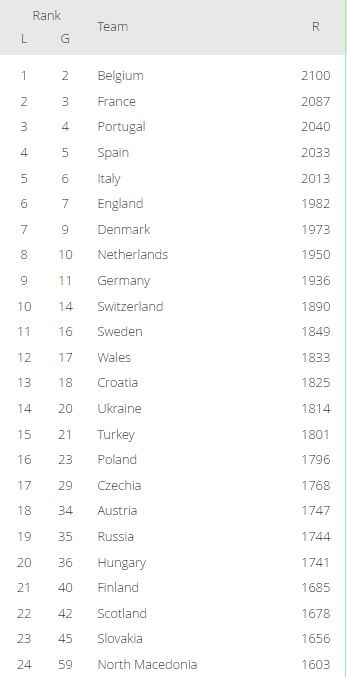

In [25]:
from IPython.display import Image
Image(filename="img/eloratings.jpg", height=600)


Even if the ranking looks plausible at first glance, there is no reason for me not to question the chosen model parameters or coefficients. To me, the football-specific adjustments seem rather arbitrary and it is not clear whether these parameters really allow for an optimal assessment of playing strength.

First, let's adjust all equations and values above. We define $W_e$ to be 
$$ W_e = \frac{1}{base^{-dr/divisor}+1} $$
where setting $base=10$ and $divisor=400$ would yield the formula applied by eloratings.net. The goal difference driven value of $K_{final}$ is generalised as follows:
$$ K_{final} = K (1 + N K_{factor})$$
where $N$ is the goal difference. Actually this is a simplification of the eloratings.net case because $K_{factor}$ is assumed to be constant. My calculations did not justify the use of different values for $K_{factor}$, so I decided to keep it simple, thus facilitating the parameter tuning later on. The same argument can be brought to the table in terms of the dependence of $K$ on the match type. Hence we define $K$ to be a fixed parameter independent from the match type.

Match type | $K$
--- | ---
World Cup final | $K$
Continental championship finals and major intercontinental tournaments | $K$
World Cup and continental qualifiers and major tournaments | $K$
All other tournaments | $K$
Friendly matches | $K$

Finally, we generalise the home advantage boost as follows:
$$ dr = (R_{0}^{Home} + home\_adv) - R_{0}^{Away} $$

We can find the optimal parameters by simulating the Elo ratings from some starting point and evaluate the results e.g. with matches from important tournaments. As the focus is on European national teams, it makes sense to use results from the European Championships as well as FIFA World Cups for that purpose. To reduce the computational effort, we restrict ourselves to tournaments after 1998 (i.e. starting with the EURO 2000). However, as each national team gets an initial Elo rating of 1500, it is appropriate to start the simulation itself some time before 2000 to give the Elo system some time to produce reasonable values. I chose the year 1990 to be the starting year for the simulation.

In [10]:
# Select all matches starting from 1990
matches_after_1989 = (results_before_euro["year"] > 1989)
results_after_1989 = results_before_euro[matches_after_1989].reset_index(drop=True)
results_after_1989

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
0,1990-01-12,Algeria,Mali,5,0,Friendly,Paris,France,True,1990
1,1990-01-14,Algeria,Cameroon,3,1,Friendly,Paris,France,True,1990
2,1990-01-17,Greece,Belgium,2,0,Friendly,Athens,Greece,False,1990
3,1990-01-17,Mexico,Argentina,2,0,Friendly,Los Angeles,United States,True,1990
4,1990-01-20,Malawi,Tanzania,2,2,Friendly,Lobamba,Eswatini,True,1990
...,...,...,...,...,...,...,...,...,...,...
26372,2021-06-09,Niger,Congo,0,1,Friendly,Antalya,Turkey,True,2021
26373,2021-06-09,Portugal,Israel,4,0,Friendly,Lisbon,Portugal,False,2021
26374,2021-06-09,United States,Costa Rica,4,0,Friendly,Sandy,United States,False,2021
26375,2021-06-10,Estonia,Latvia,2,1,Baltic Cup,Tallinn,Estonia,False,2021


We've just reduced the number of matches significantly from 42k to 26k matches.

Our goal is to find the best parameters, i.e. the parameters that maximise our prediction outcome. Points in our [Kicktipp](https://www.kicktipp.de/) prediction game are awarded according to the following table:

Prediction | Tendency | Goal difference | Result
--- | --- | --- | ---
Win | 2 | 3 | 4
Draw | 2 | 2 | 4

At this point we are only concerned about optimising the goal difference and not the final result (i.e. we make no distinction between 2-1 or 1-0). Thus, I make the simplification of this logic assuming we predict the correct result in 50% of the times given the right goal difference if it is a win, otherwise in 40%. From this we get the simplified table below:

Prediction | Tendency | Goal difference 
--- | --- | --- 
Win | 2 | 50% x 4 + 50% x 3 = 3.5 
Draw | 60% x 2 + 40% x 4 = 2.8 | 2.8

It may seem arbitrary to assume that we can predict the correct outcome of the match in 50% (for wins) or 40% (for draws) of all cases given we know the true goal difference. In fact, this can be easily justified if we look at the distribution of results.

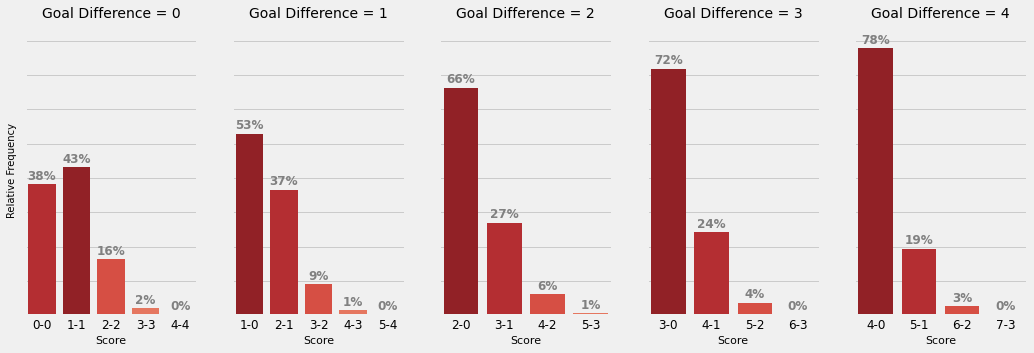

In [11]:
# Calculate the goal difference
results_count["goal_difference"] = (
    results_count["home_score"] - results_count["away_score"]
)

# Consider only matches from the 21st century
filter_epoch = results_count["epoch"] == "2000-2021"

# Create figure with five subplots
fig, axes = plt.subplots(1, 5, figsize=(16, 5))
palette = sns.color_palette("Reds", 7)

# Iterate over matches with a certain goal difference and plot the relative frequencies of each final result
for goal_diff, ax in zip(range(0, 5), axes.reshape(-1)):
    
    # Select the matches where the goal difference is equal to `goal_diff`
    filter_goal_diff = results_count["goal_difference"] == goal_diff
    score_freqs = (
        results_count[filter_goal_diff & filter_epoch]
        .value_counts(subset=["home_score", "away_score"], normalize=True)
        .sort_index()
        .reset_index()
        .rename({0: "freq"}, axis=1)
    )
    # Write the final score as string (e.g. "2-1") for use as xlabel
    score_freqs["score"] = (
        score_freqs["home_score"].astype(str)
        + "-"
        + score_freqs["away_score"].astype(str)
    )
    # Rank the resulting frequencies per final score --> will be used for coloring
    rank = score_freqs.sort_values(by="freq", ascending=False)["score"].argsort()
    
    # Create a barplot with all unique scores on the x-axis and the relative frequencies on the y-axis
    sns.barplot(
        x="score",
        y="freq",
        data=score_freqs,
        ax=ax,
        palette=np.array(palette[::-1])[rank],
    )

    # Set properties of the plot
    ax.set_title("Goal Difference = " + str(goal_diff), fontsize=14)
    ax.set_xlabel("Score", fontsize=11)
    ax.set_ylim(0, 0.85)   
    ax.set_yticklabels([])
    ax.tick_params(axis="both", which="major", labelsize=12)
    if goal_diff == 0:
        ax.set_ylabel("Relative Frequency", fontsize=10)
    else:
        ax.set_ylabel("")
    
    # Annotate the respective values
    annotate_plot(ax, score_freqs["freq"], label_format="{:.0%}")


plt.show()

Given a draw, we can conclude that predicting 1-1 has been the right guess in more than 40% of all cases in the last 21 years. If there is a winner with exactly one goal difference, then guessing 1-0 turned out to be the right guess in more than 50% of the cases, while the confidence increases the higher the goal difference gets. So if the goal difference is 2, then predicting 2-0 will already yield a certainty of approximately 66%. As a result, 50% (for wins) and 40% (for draws) can be considered rather conservative estimates for the probability of hitting the true final score given the goal difference is correct.

Now the idea is to tune the parameters $divisor$, $base$, $K$, $home\_adv$ and $K_{factor}$ such that they maximise the number of Kicktipp points. Under the hood, we make use of a function called `simulate_elos` which runs a linear regression to express the difference between the two opponents in goals based on their rating difference. 

In [31]:
from prediction_game_functions import param_grid_search_generator, simulate_elos

# Grid of parameter values to simulate over
param_grid = {
    "divisor": range(250, 291, 20),
    "base": range(7, 10, 1),
    "K": range(35, 46, 2),
    "homeadv": range(0, 5, 2),
    "K_factor": np.arange(0.56, 0.69, 0.04),
}

grid_results = pd.DataFrame(columns=list(param_grid.keys()) + ["score"])

param_grid_combinations = param_grid_search_generator(**param_grid)

n_combinations = sum(1 for x in param_grid_combinations)
print("Total number of combinations:", n_combinations)
param_grid_combinations = param_grid_search_generator(**param_grid)

for i, params in zip(range(0, n_combinations), param_grid_combinations):
    points, ratings, stdev, df_2000 = simulate_elos(df=results_after_1989, **params)
    params.update({"score": points})
    grid_results = grid_results.append(pd.DataFrame(params, index=[0]), ignore_index=True)
    if i % 50 == 0:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        best_score = grid_results["score"].max()
        print("Loop: ", i, " Time:", current_time, "Best Score so far: ", best_score) 

Total number of combinations: 648
Loop:  0  Time: 13:50:11 Best Score so far:  1.5454545454545454
Loop:  50  Time: 13:53:45 Best Score so far:  1.595959595959596
Loop:  100  Time: 13:57:03 Best Score so far:  1.595959595959596
Loop:  150  Time: 14:00:20 Best Score so far:  1.595959595959596
Loop:  200  Time: 14:03:44 Best Score so far:  1.595959595959596
Loop:  250  Time: 15:05:09 Best Score so far:  1.595959595959596
Loop:  300  Time: 15:07:53 Best Score so far:  1.595959595959596
Loop:  350  Time: 15:10:43 Best Score so far:  1.595959595959596
Loop:  400  Time: 15:13:35 Best Score so far:  1.595959595959596
Loop:  450  Time: 15:16:27 Best Score so far:  1.595959595959596
Loop:  500  Time: 15:19:26 Best Score so far:  1.595959595959596
Loop:  550  Time: 15:22:27 Best Score so far:  1.595959595959596
Loop:  600  Time: 15:25:15 Best Score so far:  1.595959595959596


So what is then the optimal set of parameters?

In [32]:
grid_results.sort_values('score', ascending=False).head()

,divisor,base,K,homeadv,K_factor,score
38,250,7,41,0,0.64,1.595960
566,290,8,45,0,0.64,1.595960
391,270,9,39,2,0.68,1.592929
634,290,9,43,4,0.64,1.592929
615,290,9,41,0,0.68,1.592929


So, $divisor = 250$, $base = 7$, $K = 41$, $homeadv = 0$, $K_{factor}=0.64$ yields an average of around 1.6 Kicktipp points per match. Given that there are 51 matches at the EURO 2020 (36 preliminary round + 8 last-16 + 4 last-8 + 2 semifinals + 1 final), this corresponds to a mean total of roughly 82 points. Not too bad, as it turns out!

Using the Central Limit Theorem, we obtain the 95% confidence interval (78.4, 84.4).

In [33]:
best_params = dict(grid_results.sort_values('score', ascending=False).iloc[0])
best_params.pop('score')
points, ratings, stdev, df_2000 = simulate_elos(df=results_after_1989, **best_params)
print("Mean:", 51 * points)
print("CI lower boundary:", 51 * points - 1.96 * stdev)
print("CI upper boundary:", 51 * points + 1.96 * stdev)

Mean: 81.39393939393939
CI lower boundary: 78.41884776578976
CI upper boundary: 84.36903102208902


Note that we make use of a linear regression (as part of the `simulate_elos` function) to predict the goal difference based on the Elo difference. This is what this relationship looks like in our fitted model.

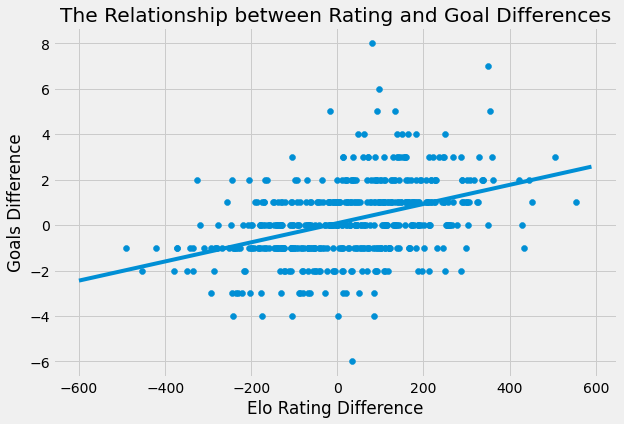

In [17]:
simulate_elos(df=results_after_1989, **best_params, plot_linreg=True)

The scatterplot above underlines that there is a positive correlation between the rating difference and the goal difference. In an optimal scenario, all points would lie on a straight line. Conversely, this would also take away any form of excitement and unpredictability from football. The fact that there is a lot of dispersion in the plot reveals the limitations of our approach. But since this approach was set up within a few days before the opening game of the EURO 2020, it seemed more important to build a reasonable model instead of finding the optimal model and question every single assumption. Surely, there is room for improvement for the next prediction game.

Let's build a few rating intervals and analyse the result in more detail.

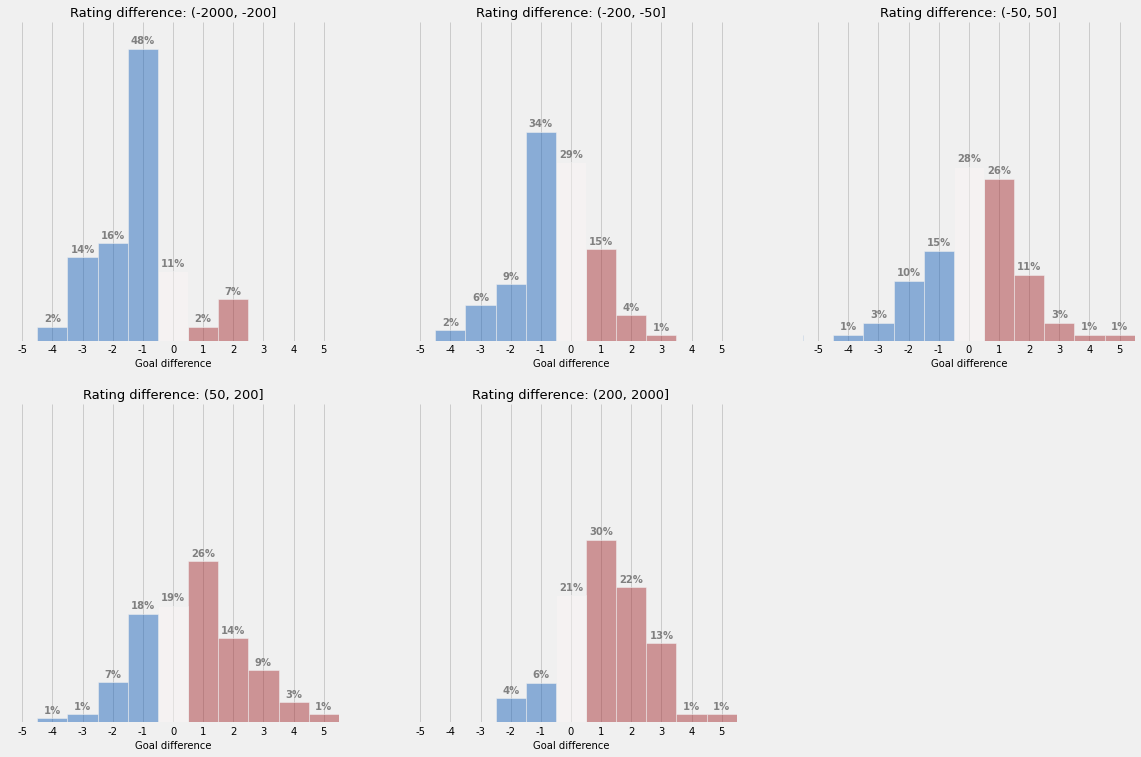

In [22]:
# Create five rating intervals
bins = [-2000, -200, -50, 50, 200, 2000]
df_2000["diff_elo_range"] = pd.cut(df_2000["diff_elo"], bins)

# Translate each score into a 3-way result --> used for hue in the barplot
def threeway_result(score):
    if score > 0:
        return 1
    elif score == 0:
        return 0
    else:
        return -1

df_2000["result_score"] = df_2000["diff_score"].apply(threeway_result)

# For each interval plot the score distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
combinations = list(product(range(0, 2), range(0, 3)))
counts = (
    df_2000[["diff_elo_range", "diff_score"]]
    .value_counts(normalize=True)
    .reset_index()
    .rename({0: "count"}, axis=1)
)

for value, (i, j) in zip(
    df_2000["diff_elo_range"].unique().sort_values(), combinations
):
    filter_range = df_2000["diff_elo_range"] == value
    plt.style.use("fivethirtyeight")
    sns.histplot(
        data=df_2000[filter_range],
        x="diff_score",
        stat="probability",
        hue="result_score",
        discrete=True,
        ax=axes[i, j],
        color="red",
        legend=False,
        palette=sns.color_palette("vlag", as_cmap=True),
    )
    axes[i, j].set_xlim(-5.5, 5.5)
    axes[i, j].set_ylim(0, 0.52)
    axes[i, j].set_title("Rating difference: " + str(value), fontsize=13)
    axes[i, j].set_ylabel("")
    axes[i, j].set_xticks(range(-5, 6))

    # Annotate the respective values
    xs = (
        df_2000.loc[filter_range, "diff_score"]
        .value_counts(normalize=True)
        .index.tolist()
    )
    ys = df_2000.loc[filter_range, "diff_score"].value_counts(normalize=True).values

    annotate_plot(axes[i, j], ys, xs=xs, label_format="{:.0%}", fontsize=10)

    declutter_plot(axes[i, j])

    axes[i, j].set_xticklabels(range(-5, 6), fontsize=10)
    axes[i, j].set_xlabel("Goal difference", fontsize=10)

# Hide the subplot at the bottom right
axes[-1, -1].axis("off")

plt.show()

The five subplots show the relative frequencies of match outcomes (more precisely: the goal difference), while the different subplots reflect the rating differences according to our Elo model. In the bar plot at the top left we see the distribution for matches in which the home team has at least 200 rating points less than the away team. In accordance with our expectations, the home team loses most of the time (roughly 78%). This value is similar to the winning frequency of the home team if it is the clear favorite (rating difference > 200), shown in the subplot at the lower middle (72%). If the rating difference is smaller, then the winning frequencies of the underdog increase. Given very similar ratings, the goal difference is almost symmetrical. In addition, the frequency of drawing is greatly increased (31%). Recall that the overall drawing frequency for international matches is around 23% in recent decades.

The following table then shows the ratings resulting from our fitted Elo system. 

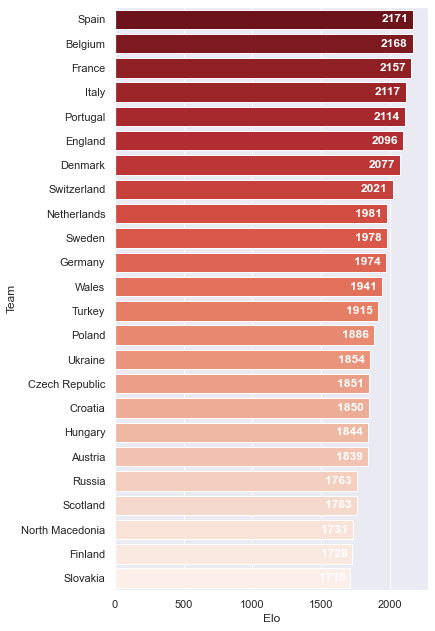

In [23]:
euro_teams = [
    "Italy",
    "Turkey",
    "Switzerland",
    "Wales",
    "England",
    "Croatia",
    "Scotland",
    "Czech Republic",
    "Denmark",
    "Finland",
    "Belgium",
    "Russia",
    "Netherlands",
    "Ukraine",
    "Austria",
    "North Macedonia",
    "Spain",
    "Sweden",
    "Poland",
    "Slovakia",
    "France",
    "Germany",
    "Portugal",
    "Hungary",
]
# Select the ratings of teams being qualified for the EURO 2020
ratings_euro2020 = ratings[ratings["Team"].isin(euro_teams)].reset_index(drop=True)

# Create a horizontal barplot
xs = ratings_euro2020["Elo"]
ys = range(0, len(ratings_euro2020["Team"]))
palette = sns.color_palette("Reds", len(xs)) 
sns.set(rc={'figure.figsize':(5, 10)})
sns.barplot(x="Elo", y="Team", data=ratings_euro2020, palette = np.array(palette[::-1]))

# Annotate the ratings
for x, y in zip(xs, ys):
    label = "{:.0f}".format(x)
    plt.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(-5, 0),
        ha="right",
        va="center",
        color="white",
        weight="bold",
        fontsize=12,
    )
plt.show()

At the beginning of the EURO 2020, the national team of Spain had a marginal lead in terms of rating. Belgium and France follow closely behind, both being the top favourites at that time. As we know of today, Italy won the EURO 2020. Although not being one of the top three, the Italian victory was no surprise at all given they were ranked fourth in terms of Elo rating. If we look at the bottom of the ranking, we find that all eight national teams being eliminated in the preliminary round are in the lower half.
## The Poisson Model
With the Elo ratings at hand, it is now time to think about a way to model the exact final result. So far we've been looking at ways to determine which team is likely to win. We also used a linear regression to express the goal difference as a function of the rating difference - with mixed results. What can be said about the distribution of goals?

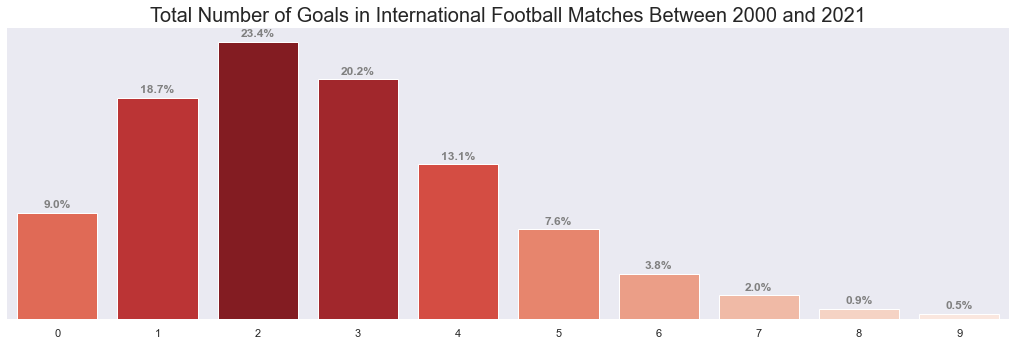

In [25]:
# Calculate the mean number of goals in each decade and save it as variable `ys`
ys = results_count.loc[results_count["epoch"] == "2000-2021", "goals"].value_counts(normalize=True).sort_index()[:10]
xs = ys.index.tolist()

# Create bar plot with epoch on the x-axis and the mean number of goals as variable y
fig, ax = plt.subplots(figsize=(16, 5))
palette = sns.color_palette("Reds", len(ys))
rank = ys.argsort().argsort()
sns.barplot(
    x=xs,
    y=ys,
    ax=ax,
    ci=False,
    palette=np.array(palette[::1])[rank],
)
plt.title("Total Number of Goals in International Football Matches Between 2000 and 2021", fontsize=20)
# plt.suptitle("Total Number of Goals in International Football Matches Between 2020 and 2021", fontsize=12, y=0.88)

# Annotate the mean number of goals on top of each bar
annotate_plot(ax, ys, label_format="{:.1%}")

# Declutter the plot
declutter_plot(ax)

plt.show()

The distribution of the total number of goals is right-skewed with mode 2 and strongly resembles a Poisson distribution. The best estimate for the Poisson parameter $\lambda$ is the Maximum Likelihood estimator $\hat{\lambda}_{ML} = \frac{1}{N}\sum_{i=1}^{N}n_{goals}$.

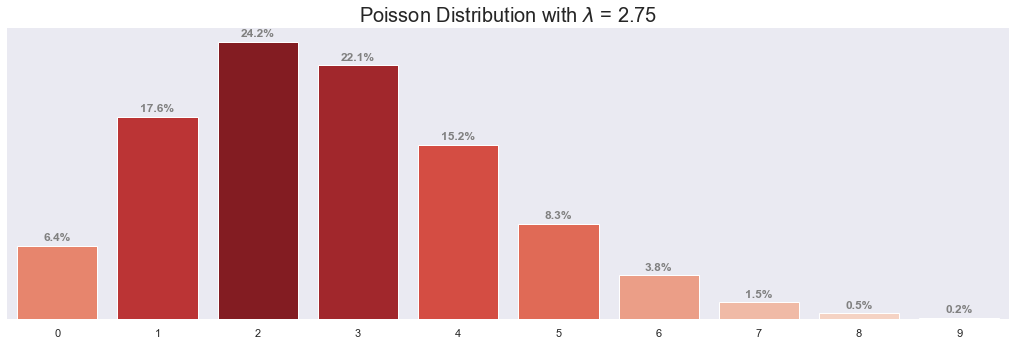

In [28]:
from scipy.stats import poisson

lambda_ml = results_count.loc[results_count["epoch"] == "2000-2021", "goals"].mean()
ys = poisson.pmf(range(0, 10), lambda_ml)
xs = [i for i in range(0, len(ys))]

# Create bar plot with epoch on the x-axis and the mean number of goals as variable y
fig, ax = plt.subplots(figsize=(16, 5))
palette = sns.color_palette("Reds", len(ys))
rank = ys.argsort().argsort()
sns.barplot(
    x=xs,
    y=ys,
    ax=ax,
    ci=False,
    palette=np.array(palette[::1])[rank],
)
plt.title("Poisson Distribution with $\lambda$ = {:.2f}".format(lambda_ml), fontsize=20)

# Annotate the mean number of goals on top of each bar
annotate_plot(ax, ys, label_format="{:.1%}")

# Declutter the plot
declutter_plot(ax)

plt.show()

The Poisson distribution with $\hat{\lambda}_{ML} = 2.75$ is quite close to the empirical distribution, although the relative frequency of seeing no goals seems to be underestimated by the model (9.0% vs 6.4%) while the opposite is the case for 2 to 5 goals. Nonetheless this should do for the prediction model.

It definitely makes sense not to stop at this point and assume that the number of goals are identically distributed, no matter who the opponents are. Some teams have an offensive style of play, while others focus more on defence. Hence, the individual parameter $\lambda$ depends on the two competing teams. Recall that the sum of multiple independent random variables $X_1 \sim Poi(\lambda_1)$, ..., $X_n \sim Poi(\lambda_n)$ is $Poi(\sum_{i=1}^{n}\lambda_i)$ distributed.

In [35]:
# Select all matches starting from 1990 including the EURO 2020
results["year"] = results["date"].dt.year
matches_after_1989 = (results["year"] > 1989)
results_after_1989 = results[matches_after_1989].reset_index(drop=True)

In [40]:
import importlib
import sys
importlib.reload(sys.modules['prediction_game_functions'])

<module 'prediction_game_functions' from 'c:\\Users\\Vale\\Documents\\MachineLearning\\EM-Tippspiel\\GitHub\\prediction_game_functions.py'>

In [41]:
from ipywidgets import interact
from prediction_game_functions import result

def predict_score(team_home, team_away, matchday):
    """ """
    _, ratings, _, _ = simulate_elos(df=results_after_1989, **best_params, due_date=matchday)
    display(result(team_home, team_away, elos=ratings, home_advantage=True, n_output_rows=10, n_games=12, sort_col="Prob", due_date=matchday))

date_list = [str(x) for x in pd.date_range(start="2021-06-11",end="2021-07-11").date]
interact(predict_score, team_home=euro_teams, team_away=euro_teams, matchday=date_list);

interactive(children=(Dropdown(description='team_home', options=('Italy', 'Turkey', 'Switzerland', 'Wales', 'E…

## Results
In the table below you can see all the predictions, the Kicktipp points (KTP) as well as the final result of the EURO 2020.
Date | Home | Away | Estimate | Exp. KTP | Result | KTP
--- | --- | --- | --- | --- | --- | ---
11 Jun 2021 | Italy | Turkey | 2:0 | 2.03 | 3:0 | 2
12 Jun 2021 | Wales | Switzerland | 0:1 | 1.49 | 1:1 | 0  
12 Jun 2021 | Denmark | Finland | 2:0 | 2.24 | 0:1 | 0
12 Jun 2021 | Belgium | Russia | 2:0 | 2.28 | 3:0 | 2
13 Jun 2021 | England | Croatia | 2:0 | 2.06 | 1:0 | 2 
13 Jun 2021 | Austria | North Macedonia | 1:0 | 1.63 | 3:1 | 2
13 Jun 2021 | Netherlands | Ukraine | 2:1 | 1.75 | 3:2 | 3
14 Jun 2021 | Scotland | Czech Republic | 0:1 | 1.53 | 0:2 | 2 
14 Jun 2021 | Poland | Slovakia | 2:0 | 1.88 | 1:2 | 0
14 Jun 2021 | Spain | Sweden | 1:0 | 1.90 | 0:0 | 0 
15 Jun 2021 | Hungary | Portugal | 0:3 | 2.17 | 0:3 | 4 
15 Jun 2021 | France | Germany | 2:0 | 1.91 | 1:0 | 2
16 Jun 2021 | Finland | Russia | 0:1 | 1.24 | 0:1 | 4 
16 Jun 2021 | Turkey | Wales | 0:1 | 1.64 | 0:2 | 2
16 Jun 2021 | Italy | Switzerland | 1:0 | 1.79 | 3:0 | 2 
17 Jun 2021 | Ukraine | North Macedonia | 1:0 | 1.86 | 2:1 | 3 
17 Jun 2021 | Denmark | Belgium | 1:2 | 1.58 | 1:2 | 4
17 Jun 2021 | Netherlands | Austria | 2:0 | 2.14 | 2:0 | 4 
18 Jun 2021 | Sweden | Slovakia | 2:0 | 2.06 | 1:0 | 2 
18 Jun 2021 | Croatia | Czech Republic | 0:1 | 1.06 | 1:1 | 0
18 Jun 2021 | England | Scotland | 2:0 | 2.26 | 0:0 | 0
19 Jun 2021 | Hungary | France | 0:2 | 2.18 | 1:1 | 0 
19 Jun 2021 | Portugal | Germany | 1:0 | 1.22 | 2:4 | 0 
19 Jun 2021 | Spain | Poland | 1:0 | 2.00 | 1:1 | 0
20 Jun 2021 | Italy | Wales | 2:0 | 2.13 | 1:0 | 2
20 Jun 2021 | Switzerland | Turkey | 3:0 | 2.16 | 3:1 | 2 
21 Jun 2021 | North Macedonia | Netherlands | 0:3 | 2.21| 0:3 | 4
21 Jun 2021 | Ukraine | Austria | 1:0 | 1.63 | 0:1 | 0
21 Jun 2021 | Finland | Belgium | 0:2 | 2.28  | 0:2 | 4
21 Jun 2021 | Russia | Denmark | 0:2 | 2.18 | 1:4 | 2 
22 Jun 2021 | Czech Republic | England | 0:1 | 2.03 | 0:1 | 4
22 Jun 2021 | Croatia | Scotland | 1:0 | 1.78 | 3:1 | 2 
22 Jun 2021 | Slovakia | Spain | 0:2 | 2.19 | 0:5 | 2 
22 Jun 2021 | Sweden | Poland | 1:0 | 1.51 | 3:2 | 3
23 Jun 2021 | Germany | Hungary | 2:0 | 2.04 | 2:2 | 0 
23 Jun 2021 | Portugal | France | 0:1 | 1.30 | 2:2 | 2
26 Jun 2021 | Wales | Denmark | 0:1 | 1.96 | 0:4 | 2
26 Jun 2021 | Italy | Austria | 2:0 | 2.24 | 2:1 | 2
27 Jun 2021 | Netherlands | Czech Republic | 1:0 | 1.58 | 0:2 | 0
27 Jun 2021 | Belgium | Portugal | 1:0 | 1.74 | 1:0 | 4
28 Jun 2021 | Croatia | Spain | 0:1 | 1.95 | 3:5 | 2
28 Jun 2021 | France | Switzerland | 2:1 | 1.49 | 3:3 | 0
29 Jun 2021 | England | Germany | 1:0 | 1.79 | 2:0 | 2
29 Jun 2021 | Sweden | Ukraine | 2:1 | 1.64 | 1:2 | 0
2 Jul 2021 | Switzerland | Spain | 1:2 | 1.48 | 1:1 | 0
2 Jul 2021 | Belgium | Italy | 2:1 | 1.07 | 1:2 | 0
3 Jul 2021 | Czech Republic | Denmark | 0:1 | 1.91 | 1:2 | 3
3 Jul 2021 | Ukraine | England | 0:1 | 2.13 | 0:4 | 2
6 Jul 2021 | Italy | Spain | 1:0 | 1.50 | 1:1 | 0
7 Jul 2021 | England | Denmark | 1:0 | 1.47 | 2:1 | 3
11 Jul 2021 | Italy | England | 1:0 | 1.12 | 1:1 | 0
**Total**||||**92.41**||**87**

As can be seen above, the model achieved 87 Kicktipp points. But the all-important question is whether I was able to finish in the top three with this result? The answer is yes. I was able to achieve an excellent third place. And if I had stuck to my model's predictions throughout (e.g. I went for Scotland against Czech Republic, shame on me!), I would even have come in second. 

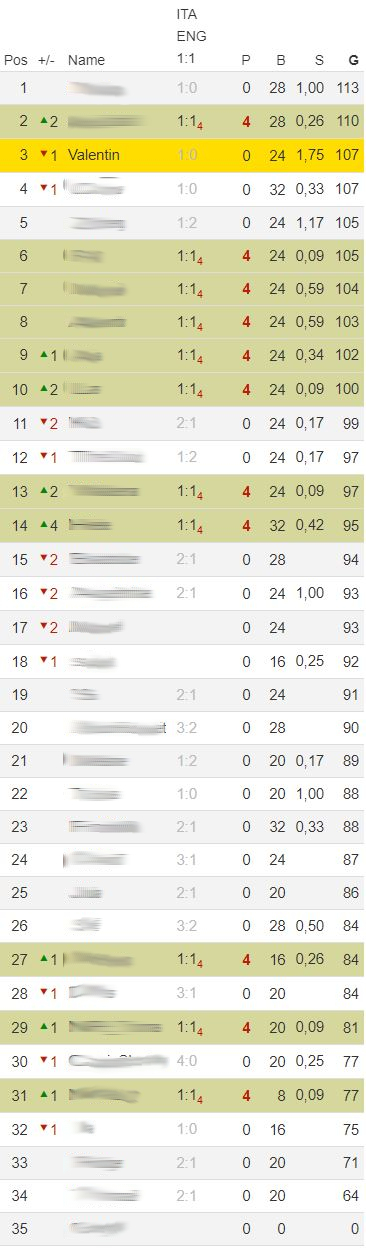

In [42]:
from IPython.display import Image
Image(filename='img/prediction_game_final_result.jpg') 

Although I did not use my model to answer the bonus questions (6 group winners, 4 semi-finalists, European champions and top scorer's team), the output would have probably been the same (24 points). In the end, the rather poor prediction of semi-finalists decided the prediction game.
## Summary
In this notebook, I have developed a model to predict final outcomes of EURO 2020. This model is based on the performance in the past matches, which is reflected in the playing strength (Elo rating) and the goal frequency (Poisson parameter $\lambda$). Although it is a very simplistic model, it achieved an outstanding result for the whole tournament. The final ranking (third out of a total of 34 participants) could have been even better if I had used the model predictions throughout. For the next prediction game I will revise the model, so better be prepared. :)